In [92]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#import janitor 
from obspy.signal.trigger import classic_sta_lta
from scipy.fft import fft, ifft, fftfreq
from scipy import signal, ndimage
from scipy.signal import find_peaks

In [93]:
class SismicDataset(Dataset):
    def __init__(self, dataset_name='luna', max_length=572427):
        self.dataset = dataset_name
        # Definir la ruta del catálogo en función del dataset
        if dataset_name == 'earth':
            self.cat = pd.read_csv('./data/EARTH/catalog/catalog_earth.csv') 
        else:
            self.cat = pd.read_csv('./data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv')
        
        # Definir la carpeta de datos según el nombre del dataset
        if dataset_name == 'earth':
            self.data_directory = './data/EARTH'
        else:
            self.data_directory = './data/lunar/training/data/S12_GradeA'
        self.max_length = max_length  # Define la longitud máxima de las secuencias

    def __len__(self):
        return len(self.cat)

    def __getitem__(self, idx):
        # Obtener los datos de la fila correspondiente
        row = self.cat.iloc[idx]
        test_filename = row['filename']
        arrival_time_rel = row['time_rel(sec)']

        # Construir la ruta al archivo .mseed
        mseed_file = os.path.join(self.data_directory, f'{test_filename}.mseed')

        # Leer los datos de la señal usando obspy
        minfreq = 0.5
        maxfreq = 3.0

        st = read(mseed_file)
        st_filt = st.copy()
        st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
        tr_filt = st_filt.traces[0].copy()
        tr_times_filt = tr_filt.times()
        tr_data_filt = tr_filt.data        
        label = arrival_time_rel

        return tr_data_filt, tr_times_filt, tr_filt.stats.sampling_rate, label

In [94]:
def get_t_from_index(index, t, delta, i):
    index = index.astype(int)
    return t[index] + delta*i

def hist_convolve_spectrogram(sxx, Nconvs):
    conv = sxx/sxx.max()
    kernel = np.ones((10, 10))
    for i in range(Nconvs):
        conv = ndimage.convolve(conv, kernel, mode='nearest')
        conv = conv/conv.max()

    hist = np.sum(conv/conv.max(), axis=0)
    hist /= hist.max()
    return hist

def get_index_list(vel,N):
    index = np.zeros(N+1)
    slices = len(vel)//N
    for i in range(N+1):
        index[i] = i*slices
    return index.astype(int)
    
def find_peaks_divided( vel, g_time, sampling_rate, Npart=2, Nconvs = 10, tolerance = 300):
    index_list = get_index_list (vel,Npart)
    delta = g_time[index_list[1]]- g_time[index_list[0]]
    peaks = np.array([])
    for i in range(Npart):
        if i < Npart - 1:
            if i % 2 ==0:
                left = index_list[i]
                right = index_list[i+2]
                vel_spectr = vel[left:right]
                peaks1, t,properties, hist = find_peaks_vel(vel_spectr,Nconvs,sampling_rate)
                peaks = np.concatenate((peaks,get_t_from_index(peaks1,t,delta, i)))
                
            else:
                left = index_list[i]
                right = index_list[i+2]
                vel_spectr = vel[left:right]
                peaks1, t,properties, hist = find_peaks_vel(vel_spectr,Nconvs,sampling_rate)
                peaks = np.concatenate((peaks,get_t_from_index(peaks1,t,delta, i)))
    
    peaks = unique_peaks(peaks, tolerance)
    return peaks, properties, hist

def find_peaks_vel(vel, Nconvs, sampling_rate):
    f, t, sxx = signal.spectrogram(vel, sampling_rate, nperseg=2000, noverlap=1800)
    hist = hist_convolve_spectrogram(sxx, Nconvs=Nconvs)
    peaks, properties = find_peaks(hist,prominence=hist.mean(),wlen=100)
    return peaks, t,properties, hist

def compare_peaks(arr1, arr2, tolerance):    
    common = []
    only_first = []
    only_second = []

    for value1 in arr1:
        if np.any(np.abs(arr2 - value1) <= tolerance):
            common.append(value1)
        else:
            only_first.append(value1)

    for value2 in arr2:
        if not np.any(np.abs(arr1 - value2) <= tolerance):
            only_second.append(value2)

    common = unique_peaks(common,tolerance)

    return {
        "100%": common,
        "50%": only_first,
        "75%": only_second
    }

def unique_peaks(peaks, tolerance = 300):
    if len(peaks) == 0:
        return np.array([])
    common_sorted = np.sort(peaks)
    filtered_values = []
    current_value = common_sorted[0]
    filtered_values.append(current_value)
    for value in common_sorted[1:]:
        if abs(value - current_value) > tolerance:
            filtered_values.append(value)
            current_value = value
    peaks = np.array(filtered_values)
    return peaks

30
{'100%': array([64.]), '50%': [530.0], '75%': []}


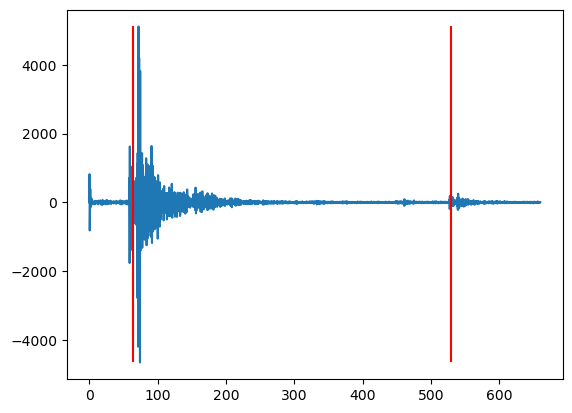

56
{'100%': array([64.]), '50%': [], '75%': []}


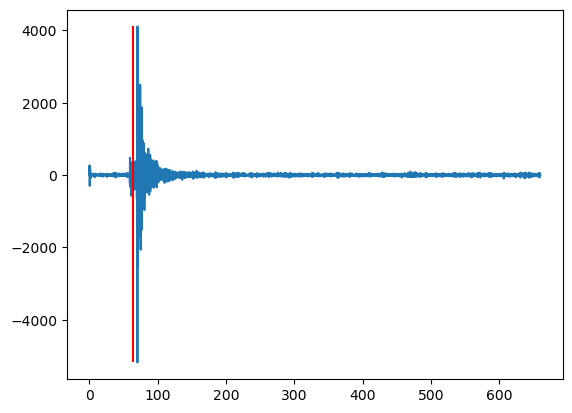

16
{'100%': array([64.]), '50%': [], '75%': []}


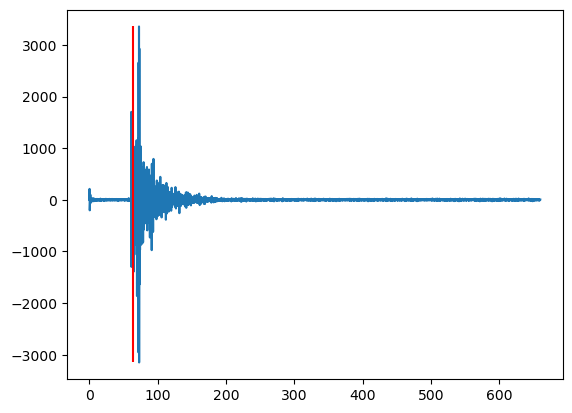

25
{'100%': array([514.]), '50%': [60.0, 152.0], '75%': []}


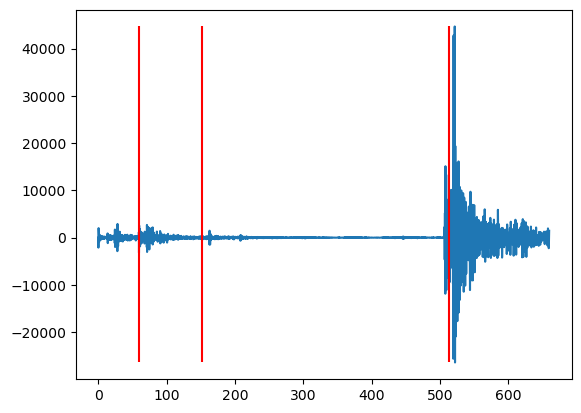

67
{'100%': array([64.]), '50%': [], '75%': []}


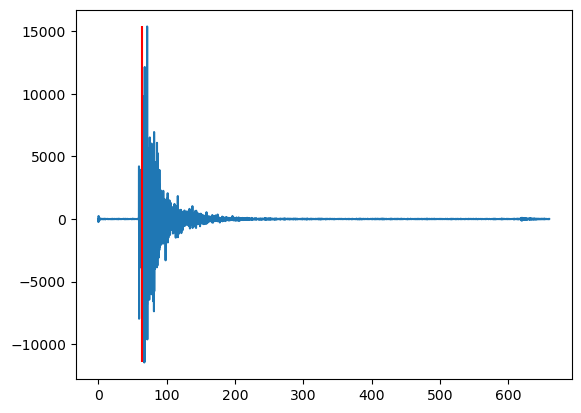

51
{'100%': array([54.]), '50%': [], '75%': []}


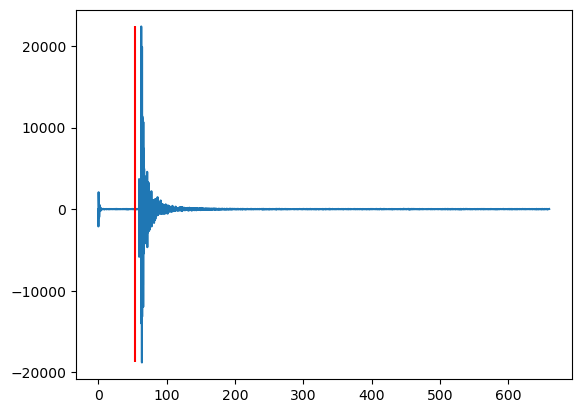

1
{'100%': array([68.]), '50%': [], '75%': []}


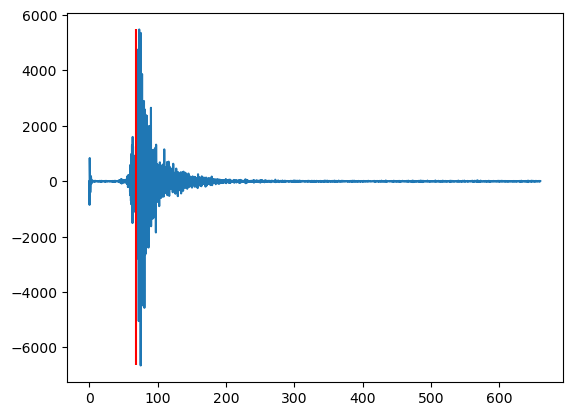

56
{'100%': array([64.]), '50%': [], '75%': []}


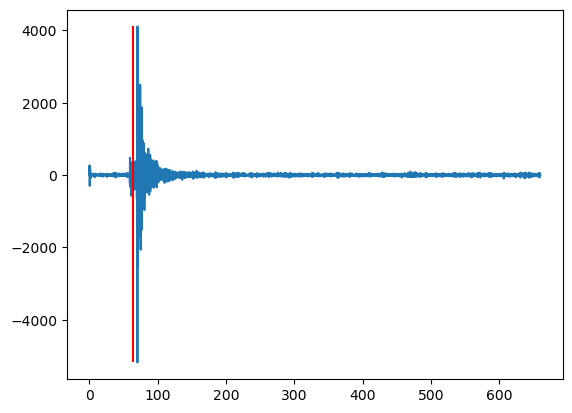

38
{'100%': array([66.]), '50%': [], '75%': []}


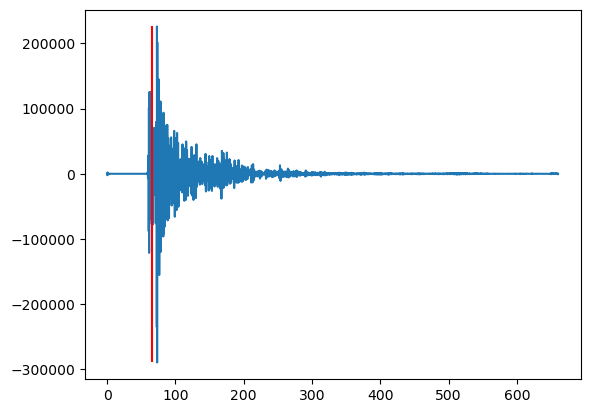

7
{'100%': array([60.]), '50%': [], '75%': []}


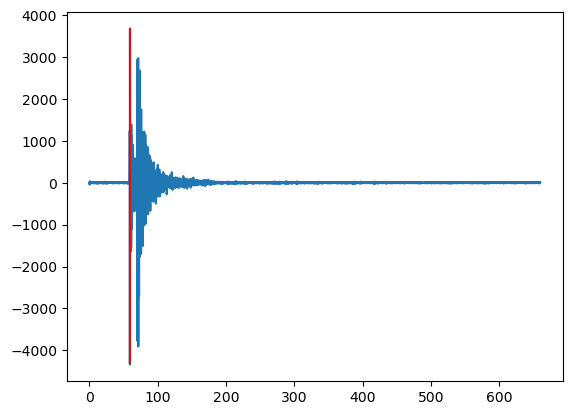

33
{'100%': array([78.]), '50%': [], '75%': []}


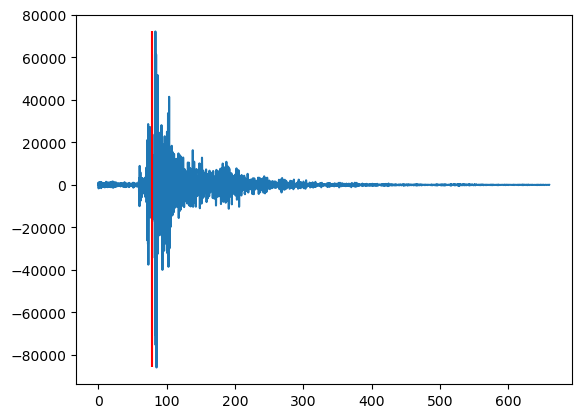

47
{'100%': array([62.]), '50%': [], '75%': []}


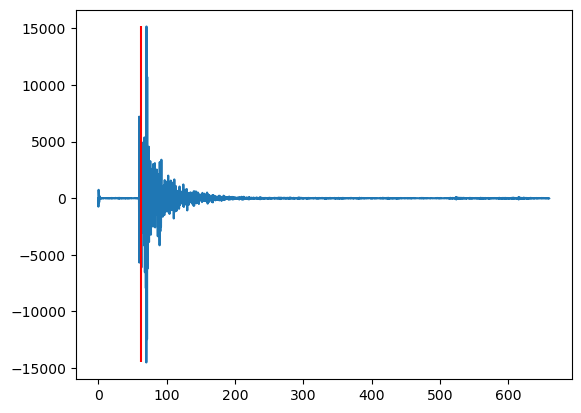

14
{'100%': array([54.]), '50%': [262.0], '75%': []}


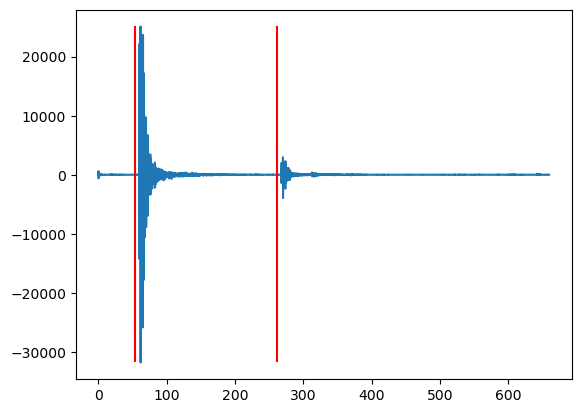

9
{'100%': array([60.]), '50%': [], '75%': []}


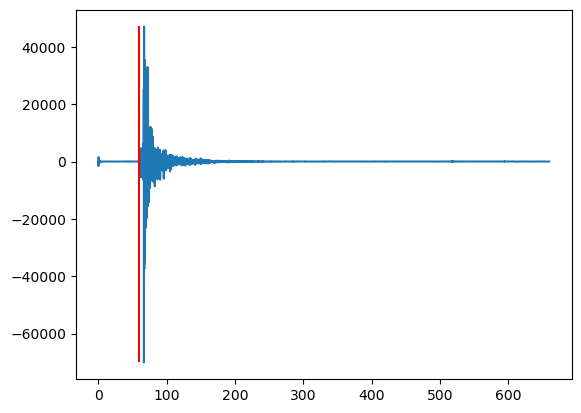

26
{'100%': array([68.]), '50%': [], '75%': []}


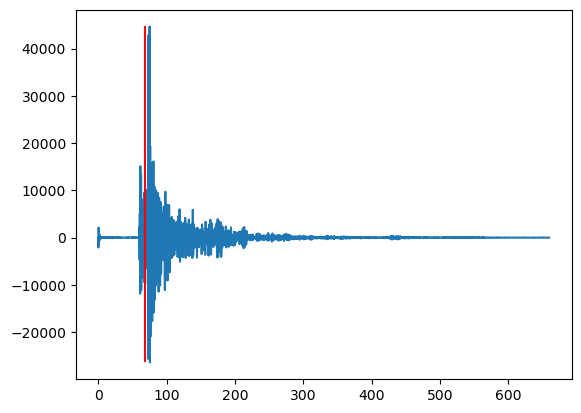

24
{'100%': array([ 72., 226.]), '50%': [], '75%': []}


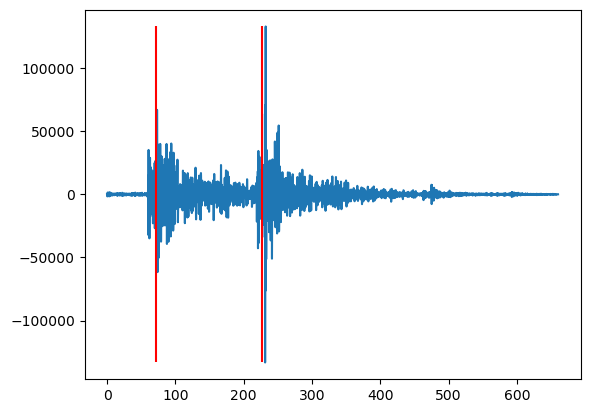

54
{'100%': array([64.]), '50%': [], '75%': []}


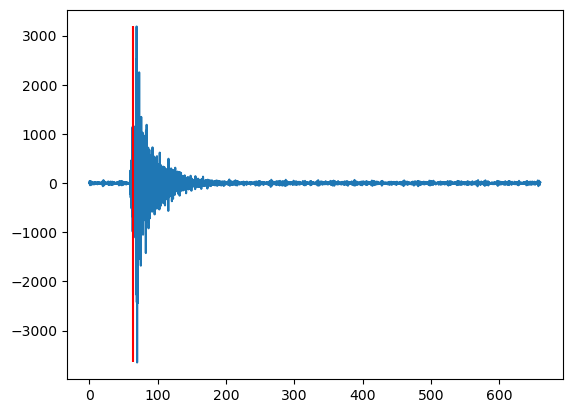

56
{'100%': array([64.]), '50%': [], '75%': []}


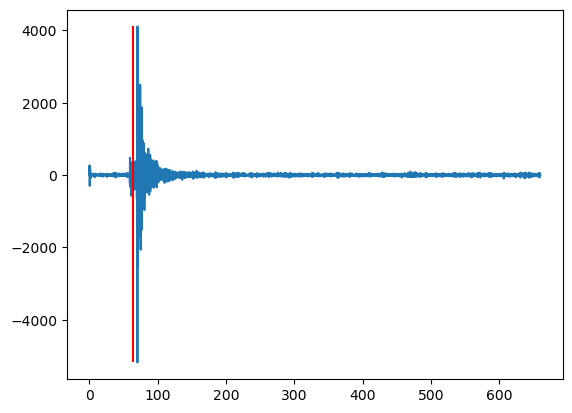

43
{'100%': array([], dtype=float64), '50%': [270.0], '75%': [62.0]}


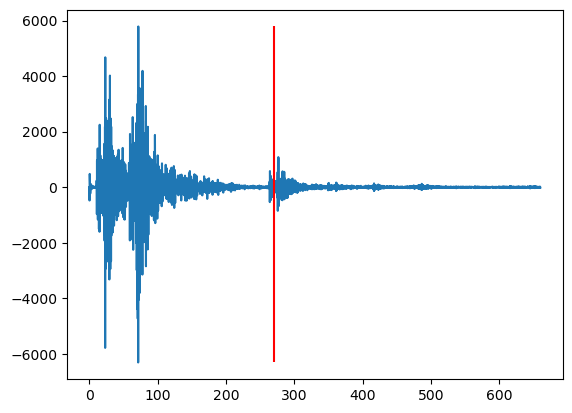

5
{'100%': array([62.]), '50%': [], '75%': []}


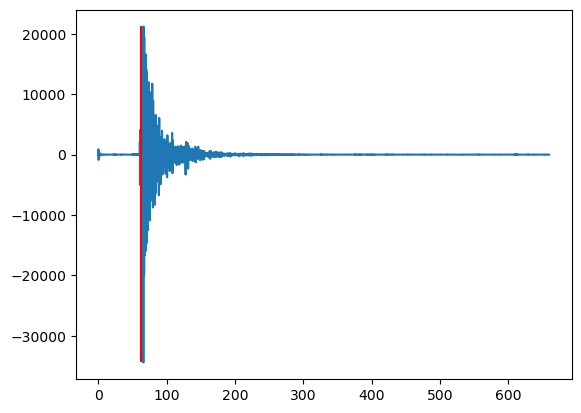

73
{'100%': array([60.]), '50%': [], '75%': []}


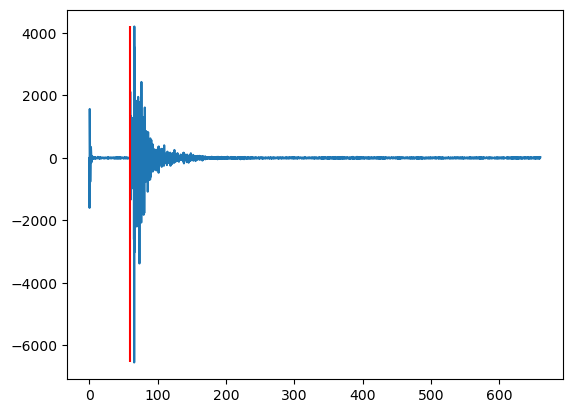

17
{'100%': array([ 66., 180.]), '50%': [], '75%': []}


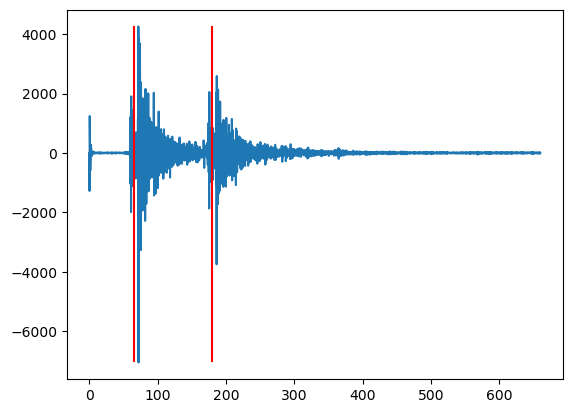

36
{'100%': array([280.]), '50%': [64.0], '75%': []}


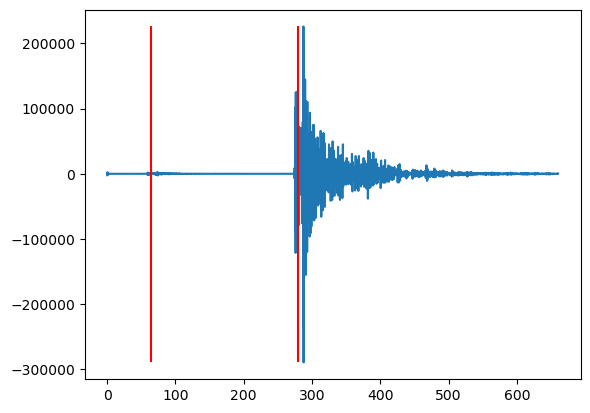

6
{'100%': array([66.]), '50%': [], '75%': []}


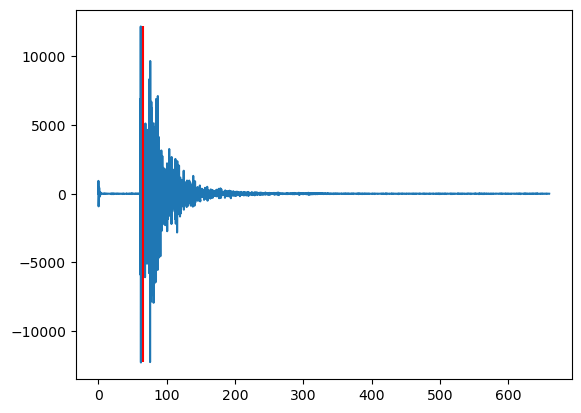

0
{'100%': array([68.]), '50%': [], '75%': []}


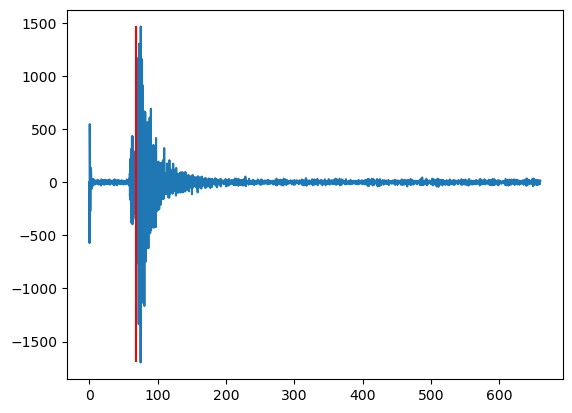

74
{'100%': array([64.]), '50%': [], '75%': []}


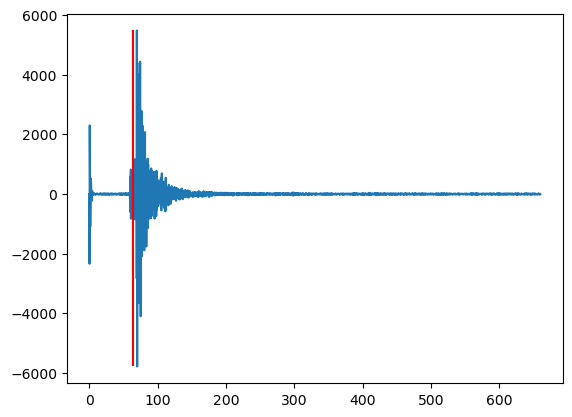

73
{'100%': array([60.]), '50%': [], '75%': []}


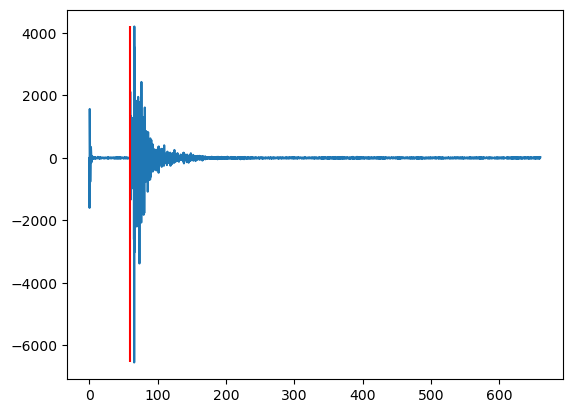

37
{'100%': array([66.]), '50%': [], '75%': []}


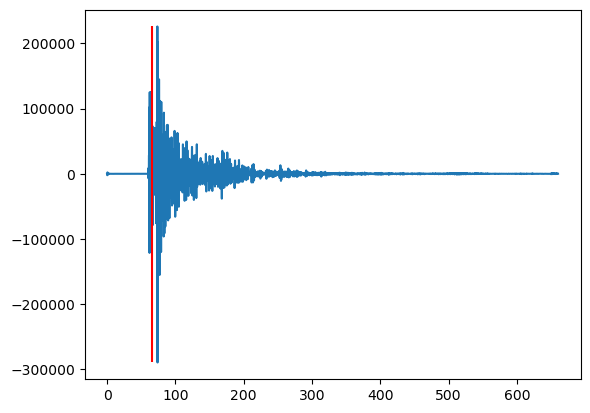

37
{'100%': array([66.]), '50%': [], '75%': []}


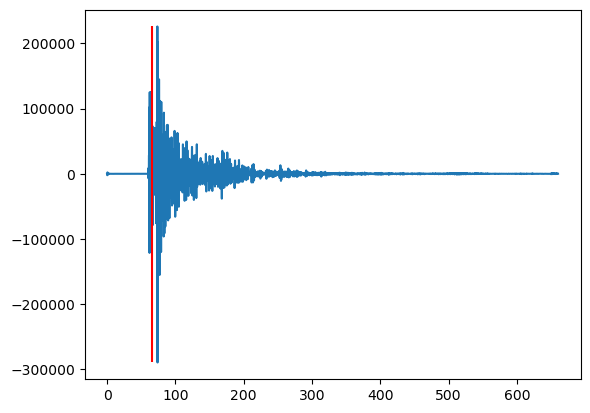

47
{'100%': array([62.]), '50%': [], '75%': []}


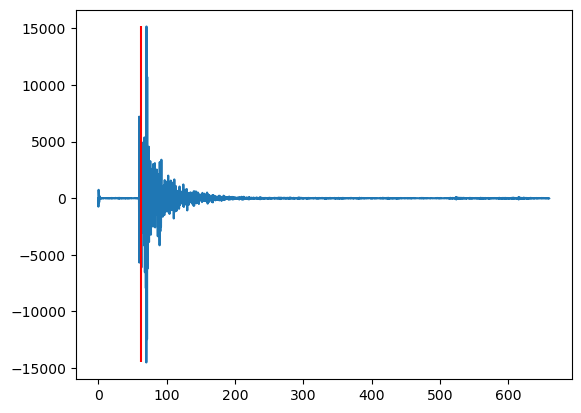

In [95]:
############MAIN##################
data = SismicDataset(dataset_name= "earth")
#x = np.arange(0,76,1)
x = np.random.randint(0,76,30)
#x = [37,57,16,24,27,42,44,50,54,75]
#x=[15]
for i in x:
    vel,time,sampling_rate, label = data.__getitem__(i)
    #f, t, sxx = signal.spectrogram(vel, sampling_rate, nperseg=2000, noverlap=1800)

    print(i)
    Npart = 6 #even
    peaks1, _, _ = find_peaks_divided(vel,time,sampling_rate,Npart, Nconvs=10,tolerance=50)
    peaks2, _, _ = find_peaks_divided(vel,time,sampling_rate, Nconvs=10,tolerance=50)
    print(compare_peaks(peaks1,peaks2,50))
    plt.plot(time,vel)
    plt.vlines(peaks1,vel.min(),vel.max(),color="red")
    plt.show()